In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metad

In [ ]:
import os
import requests

pdf_path = "human_nutrtion_text.pdf"

if not os.path.exists(pdf_path):
    print("[INFO] FIle doesn't exist, Downloading the file...")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    filename = pdf_path

    resp = requests.get(url)

    if resp.status_code==200:
        with open(filename,"wb") as file:
            file.write(resp.content)
        print(f"[INFO] file has been successfully downloaded and saved as{filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {resp.status_code}")
else:
    print(f"File {pdf_path} already exists")


[INFO] FIle doesn't exist, Downloading the file...
[INFO] file has been successfully downloaded and saved ashuman_nutrtion_text.pdf


In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str)-> str:
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text

def read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_num, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text=text_formatter(text=text)
        pages_and_texts.append({"page_number": page_num - 41,
                                 "page_char_count": len(text),
                                 "page_word_count": len(text.split(" ")),
                                 "page_sen_count": len(text.split(". ")),
                                 "page_token_count": len(text)/4,
                                  "text": text
                                })
    return pages_and_texts


In [ ]:
pages_and_texts = read_pdf(pdf_path=pdf_path)


0it [00:00, ?it/s]

In [ ]:
pages_and_texts[123]

{'page_number': 82,
 'page_char_count': 200,
 'page_word_count': 34,
 'page_sen_count': 1,
 'page_token_count': 50.0,
 'text': 'The Cardiovascular System  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Figure 2.10 The Cardiovascular system  82  |  The Cardiovascular System'}

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sen_count,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,323,57,1,80.75,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,221,11,1,55.25,! H@4A’HGE<G<BA\r \r  7<G<BA5L-A<I8E F<G...
4,-37,837,80,4,209.25,Contents 1PCD?AC 6LGTCPQG RWMD)?U?GhG? R...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sen_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1246.17,132.84,1.47,311.54
std,348.86,617.71,70.16,0.91,154.43
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,806.75,76.75,1.00,201.69
50%,562.50,1328.50,141.00,1.00,332.12
75%,864.25,1754.25,186.00,2.00,438.56
max,1166.00,2528.00,329.00,10.00,632.00


In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

### CHUNKING OUR SENTENCES TOGETHER
splitting largers pieces of text into smaller ones is often reffered to as chunking

`It is useful as text chunks can fit into our embedding model context window(384 tokens is the limit) and
so context passed to an llm can be more specific and focused`


In [ ]:
chunk_size =10

def split_list(input_list: list[str], slice_size: int = chunk_size)-> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0,len(input_list),slice_size)]



In [ ]:
for item in tqdm(pages_and_texts):
    item["sen_chunks"] = split_list(input_list=item["sentences"],slice_size=chunk_size)

    item["num_chunks"] = len(item["sen_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
import re
pages_and_chunks=[]
for item in tqdm(pages_and_texts):
    for sen_chunk in item["sen_chunks"]:

        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        joined_chunks = "".join(sen_chunk).replace("  "," ").strip()
        joined_chunks = re.sub(r'\.([A-Z])',r'.\1', joined_chunks)

        chunk_dict["sen_chunk"] = joined_chunks

        chunk_dict["chunk_char_count"] = len(joined_chunks)
        chunk_dict["chunk_word_count"] = len([word for word in joined_chunks.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_chunks)/4
        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,730.55,109.19,182.64
std,347.79,445.59,69.34,111.40
min,-41.00,12.00,3.00,3.00
25%,280.50,313.00,43.00,78.25
50%,586.00,743.00,111.00,185.75
75%,890.00,1112.00,168.00,278.00
max,1166.00,1823.00,290.00,455.75


In [ ]:
pages_and_chunks[:4]

[{'page_number': -41,
  'sen_chunk': 'Human Nutrition: 2020 Edition',
  'chunk_char_count': 29,
  'chunk_word_count': 4,
  'chunk_token_count': 7.25},
 {'page_number': -39,
  'sen_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sen_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5},
 {'page_number': -37,
  'sen_chunk': 'Contents Preface University of Hawai‘i at Mān

In [ ]:
min_token_length=30
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sen_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sen_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device="cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sen_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

In [ ]:
text_chunks = [item["sen_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
text_chunks_embed_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
text_chunks_embed_df.to_csv("embedding_df",index=False)

In [ ]:
import numpy as np
import pandas as pd
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_embeddings_df = pd.read_csv("embedding_df")


text_chunks_embeddings_df["embedding"] = text_chunks_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))


embeddings = torch.tensor(np.stack(text_chunks_embeddings_df["embedding"].to_list(), axis=0), dtype=torch.float32).to(device)


pages_and_chunks = text_chunks_embeddings_df.to_dict(orient="records")

text_chunks_embeddings_df


,page_number,sen_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,765,115,191.25,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,939,142,234.75,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1297,179,324.25,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,372,49,93.00,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1677,1165,ShareAlike 11.Organs reused “Pancreas Organ An...,1276,166,319.00,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,408,61,102.00,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [ ]:

embeddings.shape

torch.Size([1680, 768])

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device=device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from sentence_transformers import util
query="macronutrients functions"

print(f"Query: {query}")
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.02113 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [ ]:
pages_and_chunks[46]

{'page_number': 7,
 'sen_chunk': 'Figure 1.1 The Macronutrie nts: Carbohydrat es, Lipids, Protein, and Water Proteins Proteins are macromolecules composed of chains of subunits called amino acids.Amino acids are simple subunits composed of carbon, oxygen, hydrogen, and nitrogen.Food sources of proteins include meats, dairy products, seafood, and a variety of different plant- based foods, most notably soy.The word protein comes from a Greek word meaning “of primary importance,” which is an apt description of these macronutrients; they are also known colloquially as the “workhorses” of life.Proteins provide four kilocalories of energy per gram; however providing energy is not protein’s most important function.Proteins provide structure to bones, muscles and skin, and play a role in conducting most of the chemical reactions that take place in the body.Scientists estimate that greater than one-hundred thousand different proteins exist within the human body.The genetic codes in DNA are basi

In [ ]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [ ]:
query = "macronutrient"
print(f"Query: {query}")

for val, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {val:.4f}")
    print("Text")
    print_wrapped(pages_and_chunks[idx]["sen_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: macronutrient
Score: 0.6926
Text
Macronutrients Nutrients that are needed in large amounts are called
macronutrients.There are three classes of macronutrients: carbohydrates, lipids,
and proteins.These can be metabolically processed into cellular energy.The
energy from macronutrients comes from their chemical bonds.This chemical energy
is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions.A unit of measurement of
food energy is the calorie.On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand.A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels.Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are molecules composed of carbon, hy

Query: macronutrient
Score: 0.7086
Text
Macronutrients Nutrients that are needed in large amounts are called
macronutrients.There are three classes of macronutrients: carbohydrates, lipids,
and proteins.These can be metabolically processed into cellular energy.The
energy from macronutrients comes from their chemical bonds.This chemical energy
is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions.A unit of measurement of
food energy is the calorie.On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand.A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels.Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are molecules composed of carbon, hy

(-0.5, 1649.5, 2549.5, -0.5)

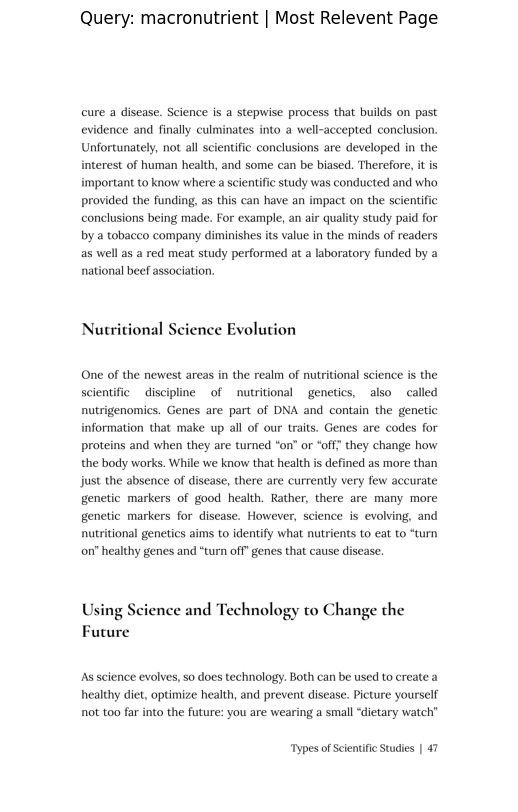

In [ ]:
import fitz as f
import matplotlib.pyplot as plt

query = "macronutrient"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
top_results_dot_product = torch.topk(dot_scores, k=5)
for val, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {val:.4f}")
    print("Text")
    print_wrapped(pages_and_chunks[idx]["sen_chunk"])

doc = f.open(pdf_path)
page = doc.load_page(88)
img = page.get_pixmap(dpi=300) #extracts the image of the page from the pdf
doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most Relevent Page")
plt.axis('off')






In [ ]:
def print_top_results(query: str, embeddings: torch.tensor, n:int=5):
    score, idx = retrieve_resources(query, embeddings, n=5)

    for val, i in zip(score, idx):
        print(f"Score: {val:.4f}")
        print("Text")
        print_wrapped(pages_and_chunks[i]["sen_chunk"])
        print(f"Page number: {pages_and_chunks[i]['page_number']}")
        print("\n")


def retrieve_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n: int=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    scores, indices = torch.topk(input=dot_scores, k=n)

    return scores, indices


In [ ]:
query="best nutrition food"

print_top_results(query,embeddings)

Score: 0.6788
Text
potatoes, broccoli, apples, mango, papaya , guavas, blueberries, and
strawberries in main and side dishes.Vary your choices to get the benefit of as
many different vegetables and fruits as you can.You may choose to drink fruit
juice as a replacement for eating fruit. (As long as the juice is 100 percent
fruit juice and only half your fruit intake is replaced with juice, this is an
acceptable exchange.)For snacks, eat fruits, vegetables, or unsalted nuts. Fill
a quarter of your plate with whole grains such as 100 percent whole-grain
cereals, breads, crackers, rice, and pasta.Half of your daily grain intake
should be whole grains.Read the ingredients list on food labels carefully to
determine if a food is comprised of whole grains. Select a variety of protein
foods to improve nutrient intake and promote health benefits.Each week, be sure
to include a nice array of protein sources in your diet, such as nuts, seeds,
beans, legumes, poultry, soy, and seafood.
Page number:

In [ ]:
pip install -U "huggingface_hub[cli]"

In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

model_id = "google/gemma-7b-it"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    # {"role": "system", "content": "You are a bot that responds to weather queries."},
    {"role": "user","content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
         16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109, 235290,   5231, 156615,  56227,  66058,
         34428,   4134,    604,    573,   2971, 23

In [ ]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

- **Carbohydrates:** Provide energy for the body. They are broken down into glucose, which is then used for energy. Carbohydrates are found in foods such as bread, pasta, rice, potatoes, and sugary drinks.
- **Proteins:** Build and repair tissues, produce enzymes and hormones, and help to regulate blood sugar levels. Proteins are found in foods such as meat, fish, eggs, dairy products, beans, lentils, and nuts.
- **Fats:** Provide energy storage and insulation. Fats are found in foods such as butter, cheese, oil, nuts, seeds, and some processed foods.

**Roles of Macronutrients:**

- **Carbohydrates:** Provide energy for the body. They are broken down into glucose, which is then used for energy. Glucose is the body's main source of ene

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

- **Carbohydrates:** Provide energy for the body. They are broken down into glucose, which is then used for energy. Carbohydrates are found in foods such as bread, pasta, rice, potatoes, and sugary drinks.
- **Proteins:** Build and repair tissues, produce enzymes and hormones, and help to regulate blood sugar levels. Proteins are found in foods such as meat, fish, eggs, dairy products, beans, lentils, and nuts.
- **Fats:** Provide energy storage and insulation. Fats are found in foods such as butter, cheese, oil, nuts, seeds, and some processed foods.

**Roles of Macronutrients:**

- **Carbohydrates:** Provide energy for the body. They are broken down into glucose, which is then used for energy. Glucose is the body's main source of energy.
- **Proteins:** Build and repair tissues, produce enzymes

In [ ]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sen_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
import random
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_resources(query=query, embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)

Query: water soluble vitamins
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: 